In [1]:
from IPython import get_ipython
get_ipython().magic('reset -sf')


In [2]:
import numpy as np
import os
from make_dataset import make_dataset
from apply_fft import  apply_fft
import matplotlib.pyplot as plt

In [3]:
num_samples = 1200 #样本点数
fs = 12000; # 采样频率

In [4]:
data_path = r'F:\Dateset\CWRU' # 数据集路径

cls_0 = '12K_DE_Normal/*'; 
cls_1 = '12k_DE_IRFault_0.007/*';   cls_2 = '12k_DE_IRFault_0.014/*';   cls_3 = '12k_DE_IRFault_0.021/*'; 
cls_4 = '12k_DE_BallFault_0.007/*'; cls_5 = '12k_DE_BallFault_0.014/*'; cls_6 = '12k_DE_BallFault_0.021/*' #'12k_DE_BallFault_0.021/*', '1772_12k_DE_BallFault_0.021/*'  
cls_7 = '12k_DE_ORFault_0.007/*';    cls_8 = '12k_DE_ORFault_0.014/*';   cls_9 ='12k_DE_ORFault_0.021/*'

norm, y_norm = make_dataset(os.path.join(data_path, cls_0), num_samples, 0)
defc1, y_defc1 = make_dataset(os.path.join(data_path, cls_1), num_samples, 1)
defc2, y_defc2 = make_dataset(os.path.join(data_path, cls_2), num_samples, 2)
defc3, y_defc3 = make_dataset(os.path.join(data_path, cls_3), num_samples, 3)
defc4, y_defc4 = make_dataset(os.path.join(data_path, cls_4), num_samples, 4)
defc5, y_defc5 = make_dataset(os.path.join(data_path, cls_5), num_samples, 5)
defc6, y_defc6 = make_dataset(os.path.join(data_path, cls_6), num_samples, 6)
defc7, y_defc7 = make_dataset(os.path.join(data_path, cls_7), num_samples, 7)
defc8, y_defc8 = make_dataset(os.path.join(data_path, cls_8), num_samples, 8)
defc9, y_defc9 = make_dataset(os.path.join(data_path, cls_9), num_samples, 9)

In [5]:
X = np.concatenate((norm, defc1, defc2, defc3, defc4, defc5, defc6, defc7, defc8, defc9), axis=0, out=None)
Y = np.concatenate((y_norm, y_defc1, y_defc2, y_defc3, y_defc4, y_defc5, 
                    y_defc6, y_defc7, y_defc8, y_defc9), axis=0, out=None)

In [6]:
import pywt

In [7]:
wavelet_function = "db4"
num_levels = 3 # 
m = 1 # 

num_features = 2**num_levels
features = np.repeat(np.nan, len(X)*m*num_features).reshape(len(X),m*num_features)

for i in range(len(X)):    
    wp = pywt.WaveletPacket(X[i], wavelet = wavelet_function, maxlevel = num_levels) # Wavelet packet transformation
    packet_names = [node.path for node in wp.get_level(num_levels, "natural")]
    for j in range(num_features):
        new_wp = pywt.WaveletPacket(data = None, wavelet = wavelet_function, maxlevel = num_levels)
        new_wp[packet_names[j]] = wp[packet_names[j]].data
        reconstructed_signal = new_wp.reconstruct(update = False) # Signal reconstruction from wavelet packet coefficients
        f, c = apply_fft(reconstructed_signal, fs, len(reconstructed_signal))
        z = abs(c)
        
        maximal_idx = np.argpartition(z, -m)[-m:]
        high_amp = z[maximal_idx]
        high_freq = f[maximal_idx]
        feature = high_amp*high_freq
        
        l = 0
        for f in feature:
            features[i,j*m+l] = f
            l = l+1

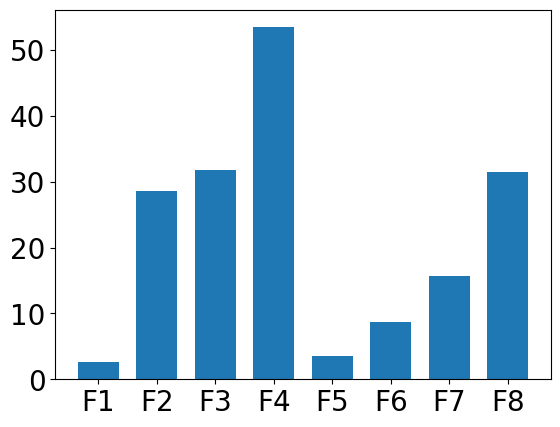

In [8]:
plt.rc('font', size=20)
X_Labels = ['F1','F2','F3','F4','F5','F6','F7','F8']
plt.bar(X_Labels, features[0], 0.7)#,  size=15)
plt.show()

In [9]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns

In [10]:
labels = pd.Categorical(Y)
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size = 0.2, 
                                            stratify = labels, random_state = 42)

# 使用StandardScaler类归一化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
## 定义超圆盘分类器类
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint  
from cvxopt import matrix,solvers 
solvers.options['show_progress'] = False

class nnhd(BaseEstimator, ClassifierMixin):
    def __init__(self,sigma=0) -> None:
        super().__init__()
        self.sigma = sigma
        self.classes = 0
        self.s_r = {}
        self.beta = {}
        self.accuracy = 0

    def gaussian_kernel(self, x1, x2):
        return np.exp(-np.linalg.norm(x1-x2)**2 / (2 * (self.sigma ** 2)))
    
    def fit(self, X, y):
        # 拟合函数
        classes = np.unique(y)
        Num = np.size(classes)
        beta = {}
        s_and_r = np.ones((Num, X.shape[1]+1+1))
        # 分类求解超圆盘对偶问题拉格朗日系数，以求解s和r
        for i, class_name in enumerate(classes):
            Xx = X[y==class_name, :]
            M = Xx.shape[0]
            P = [[self.gaussian_kernel(Xx[ii], Xx[jj]) for jj in range(M)] for ii in range(M)]
            P = 2*np.array(P)
            q = -np.diag(P)/2
            
            """ P = 2*Xx@Xx.T
            q = -np.diag(Xx@Xx.T) """
            G = np.concatenate((np.eye(M), -np.eye(M)), axis=0)
            h = np.concatenate((np.ones([M, 1]), -np.zeros([M, 1])), axis=0)
            P = matrix(np.array(P), tc='d')
            q = matrix(np.array(q), tc='d')
            G = matrix(np.array(G), tc='d')
            h = matrix(np.array(h), tc='d')
            A = matrix(np.ones([1, M]), tc='d')
            b = matrix(np.array([[1]]), tc='d')
            
            sol = solvers.qp(P, q, G, h, A, b)
            result1 = np.array(sol['x']).flatten()
            beta[class_name] = result1                  
            s = np.sum(result1.reshape(-1, 1)*Xx, 0)
            
            r = np.max(np.linalg.norm(Xx-s, ord=2,axis=1))
            s_and_r[i-1, :] = np.concatenate([[int(classes[i])], s, [r]])
            
        self.s_r = s_and_r
        self.beta = beta
   
                
    def predict(self,X):
        y_pred = np.zeros([X.shape[0], 1])
        s_r = self.s_r
        for i in range(X.shape[0]):
            y_pred[i] = s_r[np.argmin(np.linalg.norm(X[i, :]-s_r[:, 1:-1], ord=2,axis=1)), 0]
        
        y_pred = np.array(y_pred, dtype=int)
        return  pd.Categorical(y_pred.flatten())


In [12]:
# 网格搜索最佳sigma
param_grid = {'sigma': (2 ** np.arange(-5, 5.5, 0.5)).tolist()}

testmodel = nnhd()
grid_search = GridSearchCV(testmodel, param_grid=param_grid, scoring='accuracy', cv=5, verbose=5)
grid_search.fit(X_train_scaled, Y_train)
sigma = grid_search.best_params_
score = grid_search.best_score_
print(sigma, score)
sigma = sigma['sigma']
""" with open('sigma.pkl', 'wb') as f:
    pickle.dump(sigma, f) """


Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV 1/5] END .....................sigma=0.03125;, score=1.000 total time=   0.7s
[CV 2/5] END .....................sigma=0.03125;, score=1.000 total time=   0.6s
[CV 3/5] END .....................sigma=0.03125;, score=1.000 total time=   0.6s
[CV 4/5] END .....................sigma=0.03125;, score=1.000 total time=   0.6s
[CV 5/5] END .....................sigma=0.03125;, score=1.000 total time=   0.7s
[CV 1/5] END .........sigma=0.04419417382415922;, score=1.000 total time=   0.7s
[CV 2/5] END .........sigma=0.04419417382415922;, score=1.000 total time=   0.7s
[CV 3/5] END .........sigma=0.04419417382415922;, score=1.000 total time=   0.6s
[CV 4/5] END .........sigma=0.04419417382415922;, score=1.000 total time=   0.7s
[CV 5/5] END .........sigma=0.04419417382415922;, score=1.000 total time=   0.7s
[CV 1/5] END ......................sigma=0.0625;, score=1.000 total time=   0.7s
[CV 2/5] END ......................sigma=0.0625

" with open('sigma.pkl', 'wb') as f:\n    pickle.dump(sigma, f) "

In [115]:
with open('sigma.pkl', 'rb') as f:
    sigma = pickle.load(f)


In [13]:
sigma = 0.03125

In [14]:
## 训练
model = nnhd(sigma) # 必须有输入值！！
model.fit(X_train_scaled, Y_train)

In [14]:
# 测试
Y_pred = model.predict(X_test_scaled)

F1 Score = 1.0
Accuracy = 100.000 %


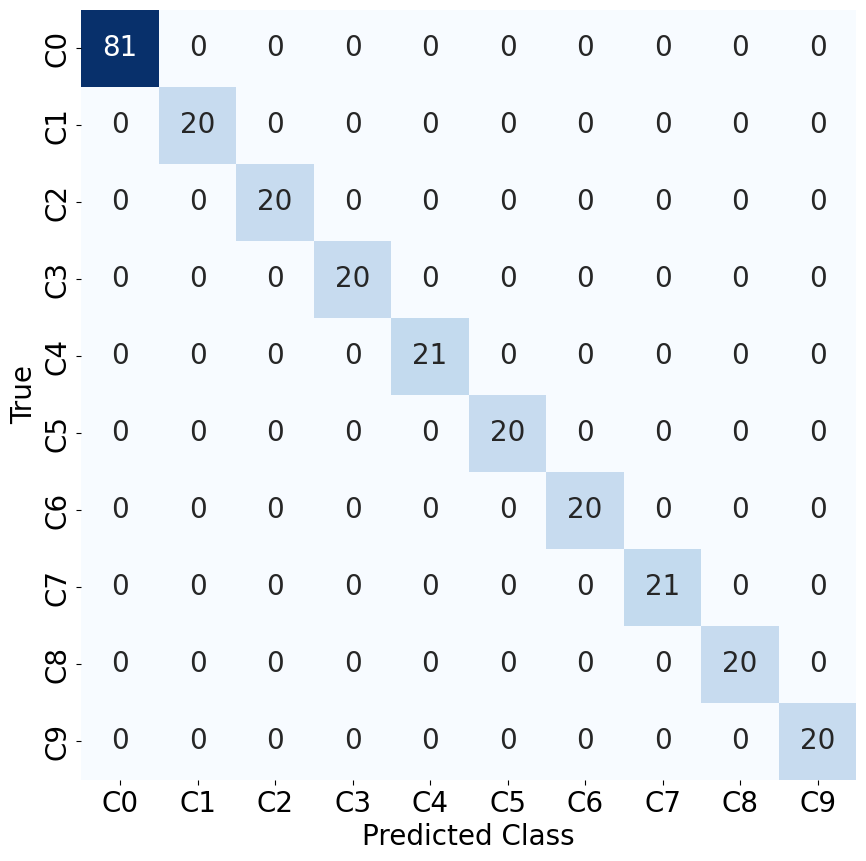

In [15]:
Accuracy = accuracy_score(Y_test, Y_pred)
test_confu_matrix = confusion_matrix(Y_test, Y_pred)
fault_type = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
plt.figure(figsize=(10, 10))
sns.heatmap(test_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.ylabel('True')
F1_score = f1_score(Y_test, Y_pred,average='micro')

print("F1 Score =", F1_score)
print("Accuracy = %.3f" % (Accuracy*100), "%")


In [119]:
BETA = model.beta
print(BETA[0])


[2.29308196e-03 1.33560400e-03 3.19899414e-05 2.68011285e-03
 2.36670152e-07 7.80307417e-03 8.03786219e-04 6.04757826e-03
 6.07238403e-04 2.71262151e-03 9.59288137e-03 3.99186530e-03
 3.78426957e-03 6.42978665e-03 6.32852040e-03 3.03925462e-03
 9.63331855e-05 2.54961619e-03 1.21839624e-03 5.94865562e-03
 1.74483837e-03 6.19149755e-03 5.31324495e-07 7.39306828e-03
 3.06883350e-05 3.27769855e-07 1.35559471e-03 3.76428460e-03
 3.21407486e-03 3.33970416e-03 7.13074305e-04 4.51692225e-03
 8.62529989e-03 4.41010431e-03 4.35729812e-03 1.76204746e-03
 6.91797028e-04 1.57183036e-07 6.91503355e-03 2.00351373e-06
 2.54691754e-03 5.94129535e-03 2.92265474e-03 3.84571166e-03
 2.00942159e-06 5.34262152e-04 8.15180212e-03 6.76181865e-03
 5.47608937e-03 9.63265972e-03 2.84230044e-07 5.80165328e-07
 8.46745759e-07 2.36038716e-03 5.57324495e-03 2.27468461e-07
 6.92570544e-03 6.62203663e-03 4.65402126e-07 2.73183785e-03
 3.40779140e-03 3.87126348e-03 1.75679724e-07 8.37587705e-05
 3.09196285e-03 4.439861

In [16]:
# 多工况测试
# 创建其余工况数据
ceshi_1 = '1730_12k_DE_IRFault_0.007/*'; ceshi_4 = '1730_12k_DE_IRFault_0.014/*'; ceshi_7 = '1730_12k_DE_IRFault_0.021/*';
ceshi_2 = '1772_12k_DE_IRFault_0.007/*'; ceshi_5 = '1772_12k_DE_IRFault_0.014/*'; ceshi_8 = '1772_12k_DE_IRFault_0.021/*';
ceshi_3 = '1797_12k_DE_IRFault_0.007/*'; ceshi_6 = '1797_12k_DE_IRFault_0.014/*'; ceshi_9 = '1797_12k_DE_IRFault_0.021/*';

ceshi_10 = '1730_12k_DE_BallFault_0.007/*'; ceshi_13 = '1730_12k_DE_BallFault_0.014/*'; ceshi_16 = '1730_12k_DE_BallFault_0.021/*'; # '1730_12k_DE_BallFault_0.021/*'   
ceshi_11 = '1772_12k_DE_BallFault_0.007/*'; ceshi_14 = '1772_12k_DE_BallFault_0.014/*'; ceshi_17 = '1772_12k_DE_BallFault_0.021/*'; # '1772_12k_DE_BallFault_0.021/*';  
ceshi_12 = '1797_12k_DE_BallFault_0.007/*'; ceshi_15 = '1797_12k_DE_BallFault_0.014/*'; ceshi_18 = '12k_DE_BallFault_0.021/*'; # '1797_12k_DE_BallFault_0.021/*'

ceshi_19 = '1730_12k_DE_ORFault_0.007/*'; ceshi_22 = '1730_12k_DE_ORFault_0.014/*'; ceshi_25 = '1730_12k_DE_ORFault_0.021/*';
ceshi_20 = '1772_12k_DE_ORFault_0.007/*'; ceshi_23 = '1772_12k_DE_ORFault_0.014/*'; ceshi_26 = '1772_12k_DE_ORFault_0.021/*';
ceshi_21 = '1797_12k_DE_ORFault_0.007/*'; ceshi_24 = '1797_12k_DE_ORFault_0.014/*'; ceshi_27 = '1797_12k_DE_ORFault_0.021/*';
       

ceshi_defc1, ceshi_y_defc1 = make_dataset(os.path.join(data_path, ceshi_1), num_samples, 1)
ceshi_defc2, ceshi_y_defc2 = make_dataset(os.path.join(data_path, ceshi_2), num_samples, 1)
ceshi_defc3, ceshi_y_defc3 = make_dataset(os.path.join(data_path, ceshi_3), num_samples, 1) 
ceshi_defc4, ceshi_y_defc4 = make_dataset(os.path.join(data_path, ceshi_4), num_samples, 2)
ceshi_defc5, ceshi_y_defc5 = make_dataset(os.path.join(data_path, ceshi_5), num_samples, 2)
ceshi_defc6, ceshi_y_defc6 = make_dataset(os.path.join(data_path, ceshi_6), num_samples, 2)
ceshi_defc7, ceshi_y_defc7 = make_dataset(os.path.join(data_path, ceshi_7), num_samples, 3)
ceshi_defc8, ceshi_y_defc8 = make_dataset(os.path.join(data_path, ceshi_8), num_samples, 3)
ceshi_defc9, ceshi_y_defc9 = make_dataset(os.path.join(data_path, ceshi_9), num_samples, 3) 
ceshi_defc10, ceshi_y_defc10 = make_dataset(os.path.join(data_path, ceshi_10), num_samples, 4)
ceshi_defc11, ceshi_y_defc11 = make_dataset(os.path.join(data_path, ceshi_11), num_samples, 4)
ceshi_defc12, ceshi_y_defc12 = make_dataset(os.path.join(data_path, ceshi_12), num_samples, 4) 
ceshi_defc13, ceshi_y_defc13 = make_dataset(os.path.join(data_path, ceshi_13), num_samples, 5)
ceshi_defc14, ceshi_y_defc14 = make_dataset(os.path.join(data_path, ceshi_14), num_samples, 5)
ceshi_defc15, ceshi_y_defc15 = make_dataset(os.path.join(data_path, ceshi_15), num_samples, 5) 
ceshi_defc16, ceshi_y_defc16 = make_dataset(os.path.join(data_path, ceshi_16), num_samples, 6)
ceshi_defc17, ceshi_y_defc17 = make_dataset(os.path.join(data_path, ceshi_17), num_samples, 6)
ceshi_defc18, ceshi_y_defc18 = make_dataset(os.path.join(data_path, ceshi_18), num_samples, 6) 
ceshi_defc19, ceshi_y_defc19 = make_dataset(os.path.join(data_path, ceshi_19), num_samples, 7)
ceshi_defc20, ceshi_y_defc20 = make_dataset(os.path.join(data_path, ceshi_20), num_samples, 7) 
ceshi_defc21, ceshi_y_defc21 = make_dataset(os.path.join(data_path, ceshi_21), num_samples, 7) 
ceshi_defc22, ceshi_y_defc22 = make_dataset(os.path.join(data_path, ceshi_22), num_samples, 8)
ceshi_defc23, ceshi_y_defc23 = make_dataset(os.path.join(data_path, ceshi_23), num_samples, 8) 
ceshi_defc24, ceshi_y_defc24 = make_dataset(os.path.join(data_path, ceshi_24), num_samples, 8) 
ceshi_defc25, ceshi_y_defc25 = make_dataset(os.path.join(data_path, ceshi_25), num_samples, 9)
ceshi_defc26, ceshi_y_defc26 = make_dataset(os.path.join(data_path, ceshi_26), num_samples, 9) 
ceshi_defc27, ceshi_y_defc27 = make_dataset(os.path.join(data_path, ceshi_27), num_samples, 9)

ceshi_X = np.concatenate((ceshi_defc1, ceshi_defc2, ceshi_defc3, ceshi_defc4, ceshi_defc5, ceshi_defc6, ceshi_defc7, ceshi_defc8, ceshi_defc9, 
                          ceshi_defc10, ceshi_defc11, ceshi_defc12, ceshi_defc13, ceshi_defc14, ceshi_defc15, ceshi_defc16, ceshi_defc17, ceshi_defc18,
                          ceshi_defc19, ceshi_defc20, ceshi_defc21, ceshi_defc22, ceshi_defc23, ceshi_defc24, ceshi_defc25, ceshi_defc26, ceshi_defc27), axis=0, out=None)
ceshi_Y = np.concatenate((ceshi_y_defc1, ceshi_y_defc2, ceshi_y_defc3, ceshi_y_defc4, ceshi_y_defc5, ceshi_y_defc6, ceshi_y_defc7, ceshi_y_defc8, ceshi_y_defc9,
                          ceshi_y_defc10, ceshi_y_defc11, ceshi_y_defc12, ceshi_y_defc13, ceshi_y_defc14, ceshi_y_defc15, ceshi_y_defc16, ceshi_y_defc17, ceshi_y_defc18,
                          ceshi_y_defc19, ceshi_y_defc20, ceshi_y_defc21, ceshi_y_defc22, ceshi_y_defc23, ceshi_y_defc24, ceshi_y_defc25, ceshi_y_defc26, ceshi_y_defc27), axis=0, out=None)


In [17]:
wavelet_function = "db4"
num_levels = 3 # 
m = 1 # 

num_features = 2**num_levels
ceshi_features = np.repeat(np.nan, len(ceshi_X)*m*num_features).reshape(len(ceshi_X),m*num_features)

for i in range(len(ceshi_X)):    
    wp = pywt.WaveletPacket(ceshi_X[i], wavelet = wavelet_function, maxlevel = num_levels) # Wavelet packet transformation
    packet_names = [node.path for node in wp.get_level(num_levels, "natural")]
    for j in range(num_features):
        new_wp = pywt.WaveletPacket(data = None, wavelet = wavelet_function, maxlevel = num_levels)
        new_wp[packet_names[j]] = wp[packet_names[j]].data
        reconstructed_signal = new_wp.reconstruct(update = False) # Signal reconstruction from wavelet packet coefficients
        f, c = apply_fft(reconstructed_signal, fs, len(reconstructed_signal))
        z = abs(c)
        
        maximal_idx = np.argpartition(z, -m)[-m:]
        high_amp = z[maximal_idx]
        high_freq = f[maximal_idx]
        feature = high_amp*high_freq
        
        l = 0
        for f in feature:
            ceshi_features[i,j*m+l] = f
            l = l+1
            
ceshi_labels = pd.Categorical(ceshi_Y)

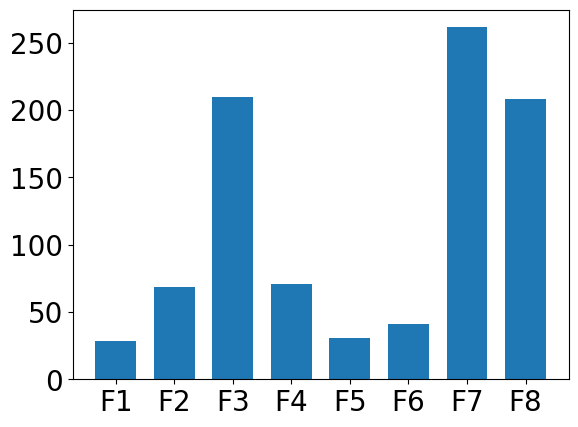

In [18]:
plt.rc('font', size=20)
X_Labels = ['F1','F2','F3','F4','F5','F6','F7','F8']
plt.bar(X_Labels, ceshi_features[0], 0.7)#,  size=15)
plt.show()

In [19]:
ceshi_X_scaled = scaler.transform(ceshi_features)

In [20]:
Multi_envpred = nnhd()

with open('s_r.pkl', 'rb') as f:
    Multi_envpred.s_r = pickle.load(f)
    # print(Multi_envpred.s_r)

ceshi_Y_pred = Multi_envpred.predict(ceshi_X_scaled)

F1 Score = 0.7529282576866765
ceshi_Accuracy = 75.293 %


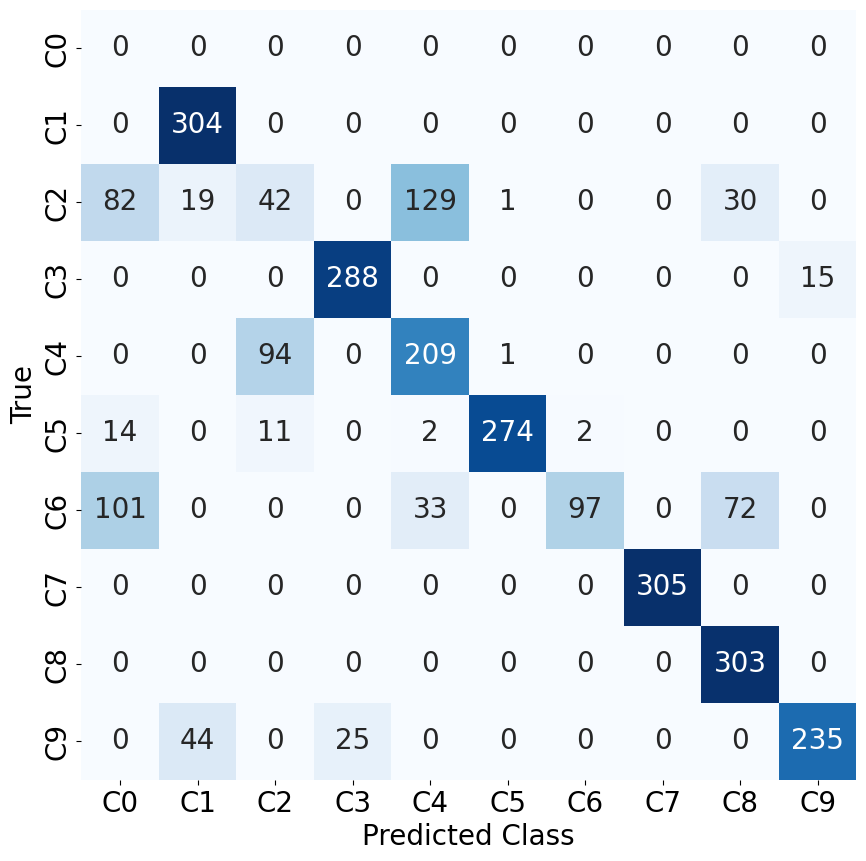

In [21]:
ceshi_Accuracy = accuracy_score(ceshi_Y, ceshi_Y_pred)
ceshi_confu_matrix = confusion_matrix(ceshi_Y, ceshi_Y_pred)
fault_type = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
plt.figure(figsize=(10, 10))
sns.heatmap(ceshi_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.ylabel('True')
F1_score = f1_score(ceshi_Y, ceshi_Y_pred,average='micro')

print("F1 Score =", F1_score)
print("ceshi_Accuracy = %.3f" % (ceshi_Accuracy*100), "%")

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.datasets import load_digits

title = r"Learning Curves (NNHD)(No Normalization)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
estimator = nnhd(sigma)
train_sizes, train_scores, test_scores = learning_curve(
    estimator, X_train, Y_train, cv=cv, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 20))



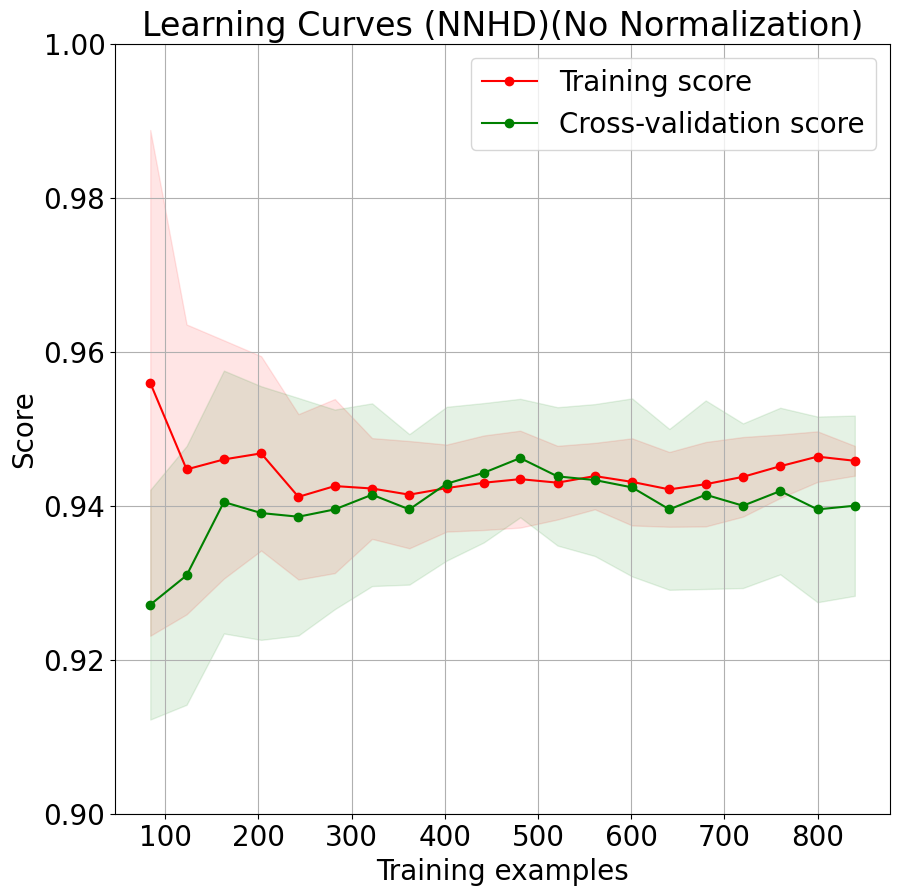

In [22]:
plt.figure(figsize=(10, 10))
plt.title(title)
ylim=(0.90, 1.00)
if ylim is not None:
    plt.ylim(*ylim)
plt.xlabel("Training examples")
plt.ylabel("Score")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")

plt.legend(loc="best")


plt.show()

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.datasets import load_digits
# NNHD模型学习曲线
title = r"Learning Curves (NNHD)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
estimator = nnhd(sigma)
train_sizes, train_scores, test_scores = learning_curve(
    estimator, X_train_scaled, Y_train, cv=cv, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 20))


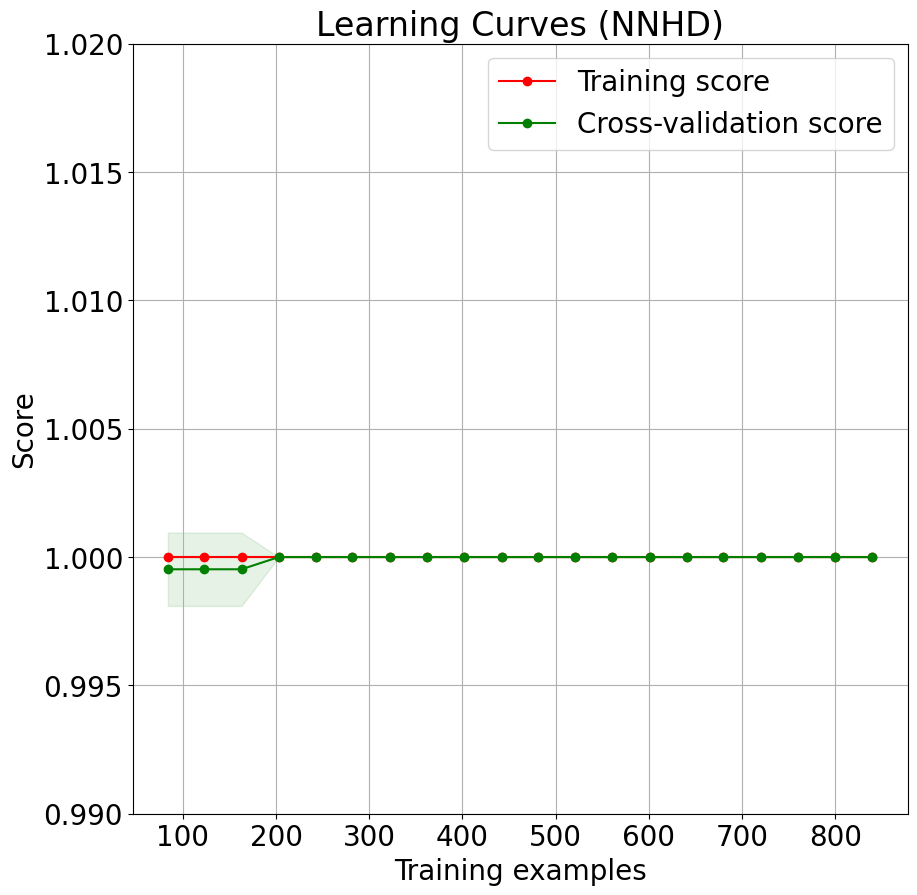

In [16]:
plt.figure(figsize=(10, 10))
plt.title(title)
ylim=(0.99, 1.02)
if ylim is not None:
    plt.ylim(*ylim)
plt.xlabel("Training examples")
plt.ylabel("Score")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")

plt.legend(loc="best")


plt.show()


In [17]:
from sklearn.naive_bayes import GaussianNB

title = "Learning Curves (Naive Bayes)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = GaussianNB()
train_sizes, train_scores, test_scores = learning_curve(
    estimator, X_train_scaled, Y_train, cv=cv, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 20))

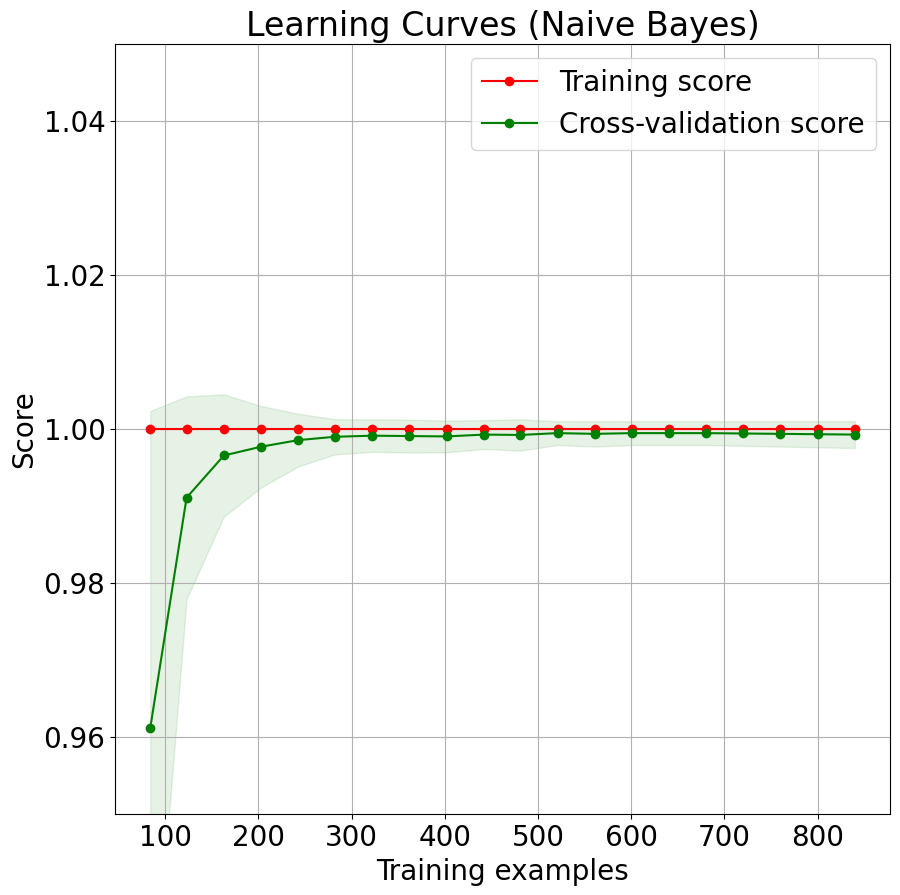

In [18]:
plt.figure(figsize=(10, 10))
plt.title(title)
ylim=(0.95, 1.05)
if ylim is not None:
    plt.ylim(*ylim)
plt.xlabel("Training examples")
plt.ylabel("Score")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")

plt.legend(loc="best")


plt.show()

In [19]:
from sklearn.svm import SVC

estimator = SVC(kernel='rbf')

# 绘制学习曲线
title = "Learning Curves (SVM, rbf kernel)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
train_sizes, train_scores, test_scores = learning_curve(
    estimator, X_train_scaled, Y_train, cv=cv, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 20))

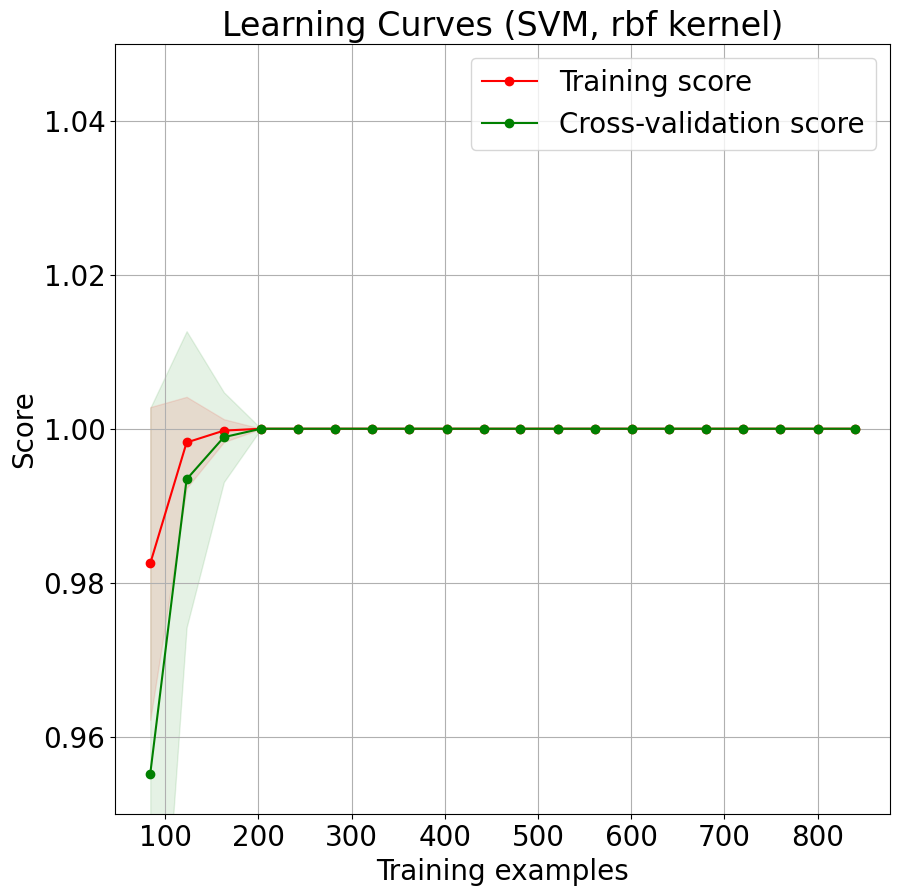

In [20]:
plt.figure(figsize=(10, 10))
plt.title(title)
ylim=(0.95, 1.05)
if ylim is not None:
    plt.ylim(*ylim)
plt.xlabel("Training examples")
plt.ylabel("Score")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")

plt.legend(loc="best")


plt.show()

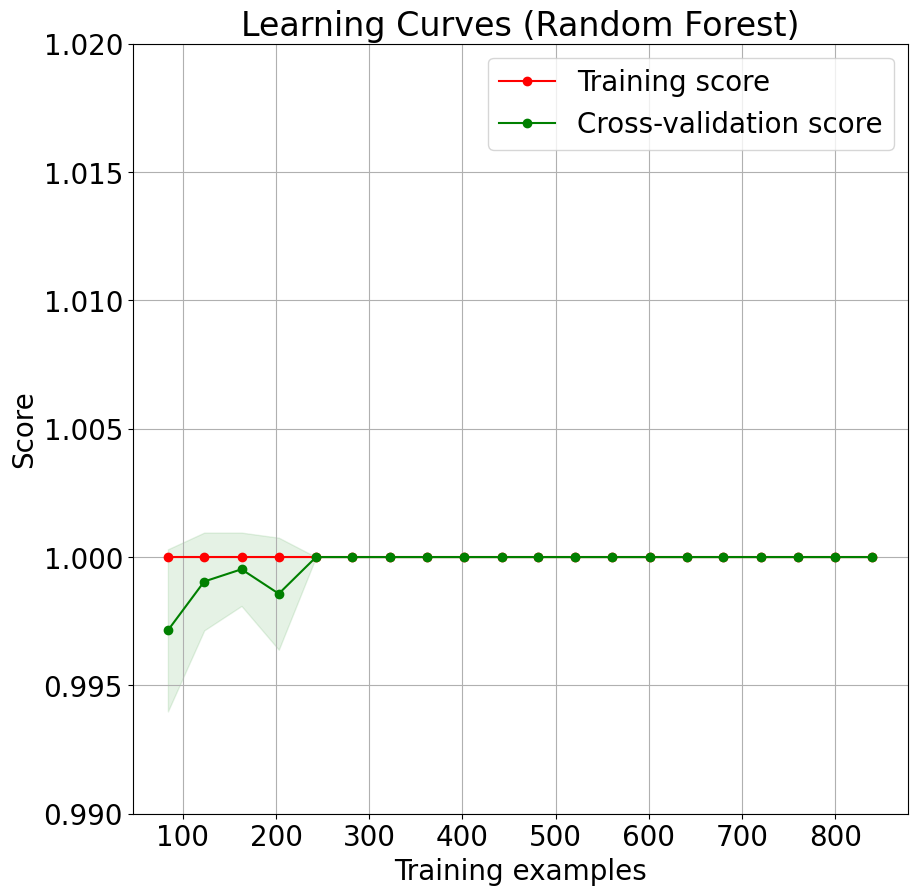

In [20]:
plt.figure(figsize=(10, 10))
plt.title(title)
ylim=(0.99, 1.02)
if ylim is not None:
    plt.ylim(*ylim)
plt.xlabel("Training examples")
plt.ylabel("Score")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")

plt.legend(loc="best")


plt.show()

In [54]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

# 网格搜索最佳sigma
param_grid = {'sigma': (2 ** np.arange(-5, 5, 0.5)).tolist()}

testmodel = nnhd()
grid_search = GridSearchCV(testmodel, param_grid=param_grid, scoring='accuracy', cv=5, verbose=5)
grid_search.fit(X, y)
sigma = grid_search.best_params_
score = grid_search.best_score_
print(sigma, score)
sigma = sigma['sigma']


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END .....................sigma=0.03125;, score=0.900 total time=   0.0s
[CV 2/5] END .....................sigma=0.03125;, score=0.933 total time=   0.0s
[CV 3/5] END .....................sigma=0.03125;, score=0.867 total time=   0.0s
[CV 4/5] END .....................sigma=0.03125;, score=0.967 total time=   0.0s
[CV 5/5] END .....................sigma=0.03125;, score=0.967 total time=   0.0s
[CV 1/5] END .........sigma=0.04419417382415922;, score=0.900 total time=   0.0s
[CV 2/5] END .........sigma=0.04419417382415922;, score=0.933 total time=   0.0s
[CV 3/5] END .........sigma=0.04419417382415922;, score=0.867 total time=   0.0s
[CV 4/5] END .........sigma=0.04419417382415922;, score=0.967 total time=   0.0s
[CV 5/5] END .........sigma=0.04419417382415922;, score=0.967 total time=   0.0s
[CV 1/5] END ......................sigma=0.0625;, score=0.900 total time=   0.0s
[CV 2/5] END ......................sigma=0.0625

In [60]:
title = r"Learning Curves (NNHD)(iris)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
estimator = nnhd(sigma)
train_sizes, train_scores, test_scores = learning_curve(
    estimator, X, y, cv=cv, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 20))

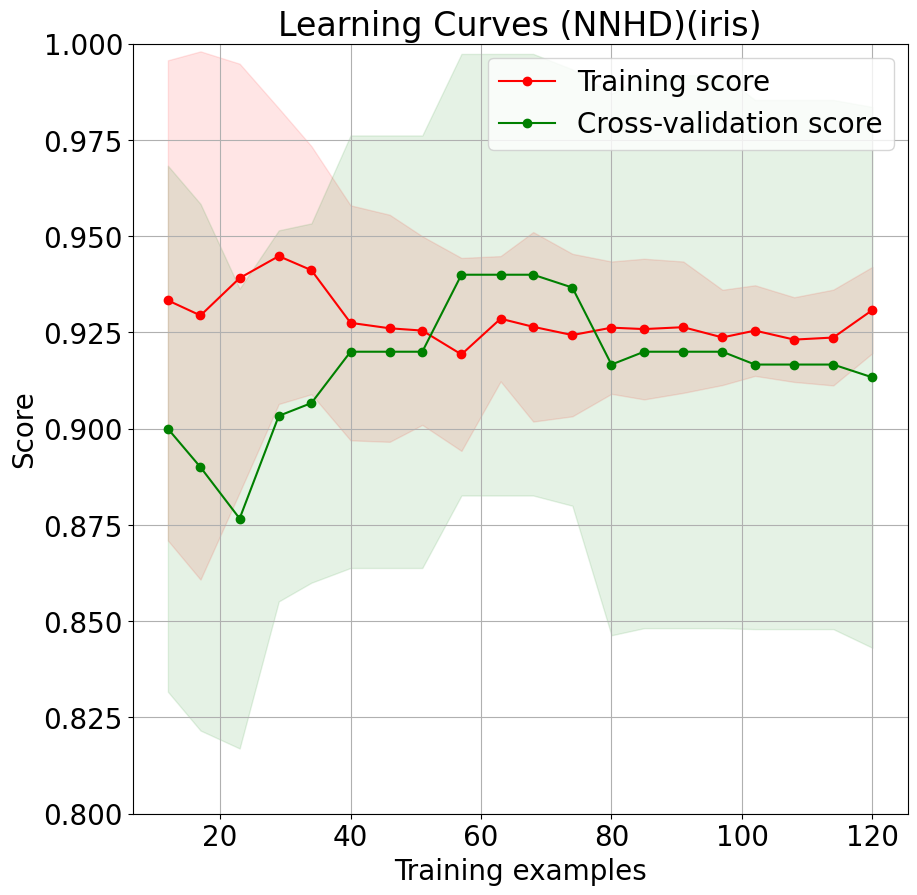

In [61]:
plt.figure(figsize=(10, 10))
plt.title(title)
ylim=(0.8, 1)
if ylim is not None:
    plt.ylim(*ylim)
plt.xlabel("Training examples")
plt.ylabel("Score")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")

plt.legend(loc="best")


plt.show()

In [64]:
from sklearn.ensemble import RandomForestClassifier

title = r"Learning Curves (RandomForest)(iris)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
estimator = RandomForestClassifier()
train_sizes, train_scores, test_scores = learning_curve(
    estimator, X, y, cv=cv, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 20))

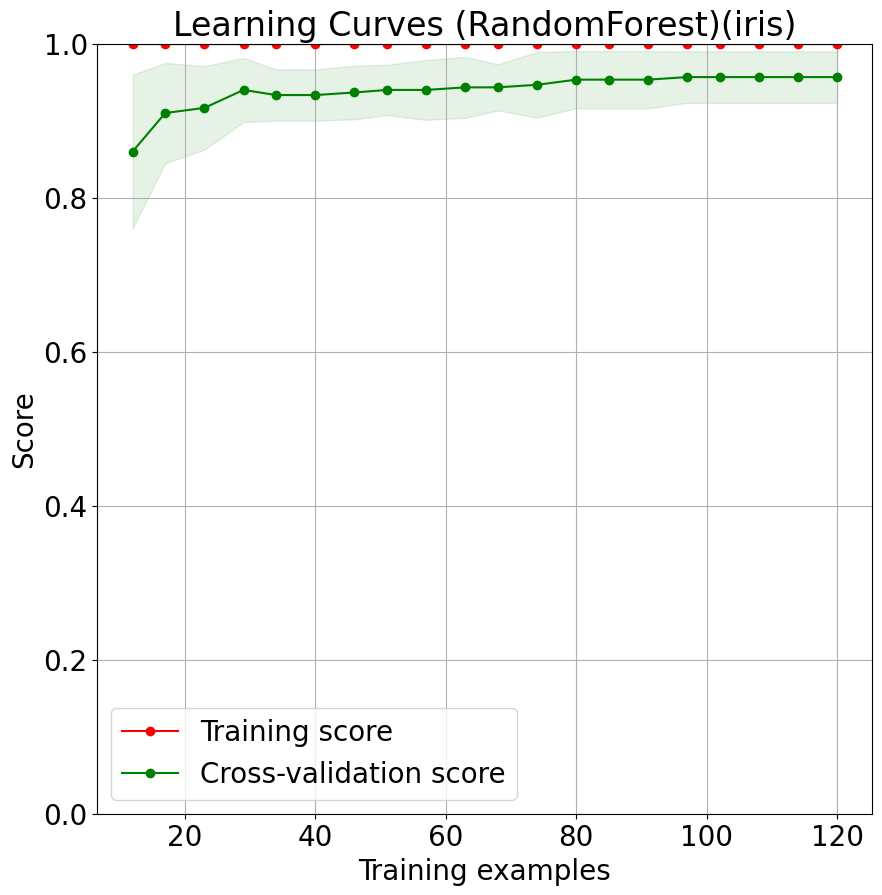

In [65]:
plt.figure(figsize=(10, 10))
plt.title(title)
ylim=(0, 1)
if ylim is not None:
    plt.ylim(*ylim)
plt.xlabel("Training examples")
plt.ylabel("Score")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")

plt.legend(loc="best")


plt.show()